# Visualize competitive qpAdm Models

In [2]:
import numpy as np
import os  # For Saving to Folder
import pandas as pd
import matplotlib.pyplot as plt

import socket
import os as os
import sys as sys
import multiprocessing as mp
import itertools as it
from time import time
from matplotlib import gridspec

# For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
# Make sure to have the font installed (it is on cluster for Harald)
rcParams['font.sans-serif'] = ['Arial']

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/punic_aDNA/"  # The Path on HMS Cluster
else:
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
# Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")
print(sys.version)

compute-e-16-233.o2.rc.hms.harvard.edu
HSM Computational partition detected.
/n/groups/reich/hringbauer/git/punic_aDNA
CPU Count: 28
3.7.4 (default, Sep 11 2019, 11:24:51) 
[GCC 6.2.0]


In [3]:
###################################################
###################################################
### Define Plot functions

def fig_admix(axes=[], res=[], p_vals=[], target_pops=[], 
              source_pops=[], figsize=(12,8), 
              save_path="", lw=2,
              pval_lim=[1e-6,1.0], stds=[], 
              l_pos = (1, 0.5), fs = 12, bw = 0.85, 
              c=[], ec = "white", show=False,
              height_ratios=[1, 8],
              rotation=90, legend=True):
    """Plot a Figure of the admixture coefficients.
    axes: 2 axis where to plot Fractions and p-Values onto
    res: nxk Array of Results
    p_vals: Array of p-Vals [n]
    target_pops: String Array of Target Pops [n]
    source_pops: String Array of Source Pops [k]
    stds: Standard Errors. If none are given do not plot them
    l_pos: Where to place the Legend.
    lw: Linewidth of bar"""
    # Create Pandas Dataframe for Plot
    #pd.DataFrame(data=target_pops, index=r, columns=source_pops)
    
    ### Define Axes if not given
    if len(axes)==0:
        fig, axes = plt.subplots(nrows=2, ncols=1,
                                 gridspec_kw={'height_ratios': height_ratios}, 
                                 figsize=figsize)
    ax0, ax1 = axes
    
    # Plot Parameters
    r = np.arange(len(target_pops))
    barWidth = bw
    if len(c)==0:
        c=["DeepPink", "MediumBlue", "purple", "yellowgreen", "gold"]
    
    for i, s in reversed(list(enumerate(source_pops))): # From last to first (For Legend)
        s = source_pops[i]
        b = np.sum(res[:,:i], axis=1)
        ax1.bar(r, res[:,i], bottom=b, color=c[i], edgecolor=ec, width=barWidth, label=s, alpha=0.9)
        
        if len(stds)>0: # Plot some standard deviations.
            ax1.errorbar(r, b+res[:,i], yerr=stds[:,i], fmt='none', linewidth=lw, color="k")
    
    ### Add the Model not viable bars:
    su = np.sum(res, axis=1)
    sum0ids = np.where(su==0)[0]
    
    for i in sum0ids:
        ax1.bar(i, 1, color="lightgray", edgecolor='white', width=barWidth, alpha=0.9)
     
    ################
    # Custom x axis
    ax1.set_xticks(r)
    ax1.set_xticklabels(target_pops, fontsize=fs, rotation=rotation)

    # Add a legend
    #l1 = ax1.legend(loc=l_pos, bbox_to_anchor=(1, 0.5), ncol=1, fontsize=fs)
    if legend:
        l1 = ax1.legend(bbox_to_anchor=l_pos, ncol=1, fontsize=fs)
        l1.set_title('Sources: ', prop={'size':fs})
    
    ax1.set_ylabel("Fraction Ancestry", fontsize=fs*1.5)
    ax1.set_ylim([0,1])
    ax1.set_xlim([-0.6, len(target_pops)-0.4])
    
    ax0.set_yscale("log")
    ax0.set_ylim(pval_lim)
    ax0.bar(r, p_vals, color="grey", width=barWidth, alpha=0.8, zorder=1)
    ax0.axhline(y=0.05, color='r', zorder=0)
    ax0.set_ylabel("p-Val", fontsize=fs)
    ax0.set_xlim([-0.6,len(target_pops)-0.4])
    ax0.set_xticks([])
    
    # Adjust position of subplots
    #plt.subplots_adjust(left=0, bottom=0.05, right=None,
    #            wspace=0, hspace=0.06)
    
    if len(save_path) > 0:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0)
        print("Saved to %s" % save_path)
        # Save the .csv of the Results
    
    if show:
        plt.show()
        
def plot_qpadm(dir_path, test_pops, save_path="", l_pos = (0.4, 1.15), 
               best=True, figsize=(12,8), bw = 0.85, lw=2,
               height_ratios = [1,8],
               c=[], ec="white", fs=10, pval_lim = [1e-3,1],
               latex=False, dataframe=False):
    """Do 3 Way Admixtures of Sardinia
    best: Whether to use highest p-Val Submodel: 0 use the first, 
    True use the best p-Value, 
    else use the old (first feasible)"""
    admix_coeffs = []
    p_vals = []
    pops_t = [] 
    stds = []
    pr = False # Print the statistics

    #for filename in os.listdir(dir_path):
    for f in test_pops:
        full_path = dir_path + str(f) + ".log" # Other "outputMycSicily_"
        res, p_val_ls, pops, std = load_qp_adm(full_path)

        pops_t.append(pops[0])
        
        if best == 0:
            i = give_admix0(res)   # Give the first result (if feasible)
            
        elif best == True:
            i = give_admix_index_best(res, p_val_ls) # Give the best feasible p-Value
        
        else:
            i = give_admix_index(res)
            
        #### Handle Not fitting Models  
        if np.isnan(i): # In Case no valid admixture:
            new_res = np.zeros(np.shape(res)[1]) # Not Plot anything
            std = np.zeros(np.shape(res)[1])     # Not Plot anything
            new_p = -1 # For Sorting
        
        else:
            new_res = res[i,:]
            new_p = p_val_ls[i]
        
        admix_coeffs.append(new_res)
        p_vals.append(new_p)
        stds.append(std)

        if pr == True:
            print("Population: %s" % f)
            print(res[i,:])
            print(std)
            print(p_val_ls[i])

    admix_coeffs, stds = np.array(admix_coeffs), np.array(stds)
    source_pops = pops[1:]
    
    fig_admix(res=admix_coeffs, 
              p_vals=p_vals, 
              target_pops=pops_t, 
              source_pops=source_pops, 
              pval_lim=pval_lim, 
              stds=stds, save_path = save_path, 
              l_pos = l_pos, lw=lw,
              height_ratios=height_ratios,
              fs=fs, figsize=figsize, 
              bw = bw, c=c, ec = ec)
    
    if latex:
        source_pops = [([t] + pops[1:]) for t in pops_t]
        create_latex_lines(source_pops, admix_coeffs, stds, 
                           p_vals, na = "-", rp = "A15")
        
    if dataframe:
        source_pops = np.array([([t] + pops[1:]) for t in pops_t])
        df = create_admix_df(source_pops, admix_coeffs, stds, p_vals)
        return(df)
    
    
def plot_qpadm_split(dfs, sources=[], figsize=(12,8), labels=[],
                     bw = 0.85, lw=2,
                     c=[], ec="white", fs=10, 
                     height_ratios=[1, 10], wspace=0.05, hspace=0.05,
                     pval_lim = [1e-3, 1], pr=False, save_path="", 
                     leg_pos=1,legend=True, l_pos=(1, 0.5)):
    """Do 3 Way Admixtures of Sardinia
    best: Whether to use highest p-Val Submodel: 0 use the first, True use the best p-Value, 
    else use the old (first feasible)
    test_pops: List of lists: Will be split up into subdataframes
    pr: whether to print output"""
    
    ### Prepare the Full Figure Layout
    fig = plt.figure(figsize=figsize)
    
    width_ratios = list(map(len, dfs))
    gs = gridspec.GridSpec(2, len(dfs), 
                           width_ratios = width_ratios, 
                           height_ratios = height_ratios, 
                           figure = fig)
    
    gs.update(wspace=wspace, hspace=hspace) # set the spacing between axes
    
    ### Iterate over all Populations
    k = len(sources)
    
    for j, df in enumerate(dfs):   
        ######################
        ### Load the Data
        admix_coeffs = df[[f"f{i}" for i in range(1,k+1)]].values
        stds = df[[f"std{i}" for i in range(1,k+1)]].values
        p_vals = df["p"].values
        pops_t = df["t"].values 
        
        ######################
        ### Do the actual Plot
        ax_adm = fig.add_subplot(gs[0, j])
        ax_p = fig.add_subplot(gs[1, j])
        
        if j>0:
            legend=False
            
        fig_admix(axes=[ax_adm, ax_p], res=admix_coeffs, 
                  p_vals=p_vals, target_pops=pops_t, 
                  source_pops=sources, pval_lim=pval_lim, 
                  stds=stds, save_path = "", 
                  lw=lw, fs=fs, figsize=figsize, 
                  bw = bw, c=c, ec = ec, show=False,
                  legend=legend, l_pos = l_pos)
        
        ### Turn off the Labels for all but first plot
        if j>0:
            for ax in [ax_p, ax_adm]:
                ax.set_yticklabels([])
                ax.set_ylabel("")
                
        if len(labels)>0:
                ax_adm.set_title(labels[j], fontsize=fs)
            
    if len(save_path) > 0:
        plt.savefig(save_path, bbox_inches = 'tight', 
                    pad_inches = 0)
        print("Saved to %s" % save_path)
        # Save the .csv of the Results
    plt.show()
    
### Helper Function
def set_feasible_df(df, sources=5):
    """Set Feasible Models"""
    
    fs = [f"f{i}" for i in range(1,sources+1)]

    idx_if = np.nanmin(df[fs], axis=1) < 0
    df["fs"] = True
    if np.sum(idx_if)>0: # Reset Values if infeasible idx
        df.loc[idx_if, "fs"] = False
    
    print(f"Set {np.sum(idx_if)}/{len(idx_if)} infeasible models")
    return df

def get_spec_model(df, sources=[], tot_sources=5, 
                   drop=True, output=True):
    """Get specific model for dataframe df.
    Return dataframe with this model."""
    k = len(sources)
    found = np.ones(len(df), dtype="bool")
    for i in range(1,k+1):
        idx = df[f"s{i}"].isin(sources)
        found = found & idx
    for i in range(k+1, tot_sources+1): 
        idx = df[f"s{i}"].isnull()
        found = found & idx
        
    if output: 
        print(f"Found {np.sum(found)} fitting rows.")
    dft = df[found]
    
    ### Drop Unnecessary Labels
    if drop:
        for i in range(k+1, tot_sources+1):
            dft = dft.drop(columns=[f"s{i}", f"f{i}", f"std{i}"])
    
    return dft.reset_index(drop=True).copy()

def df_excl_source(df, exclude=[], tot_sources=5, 
                     output=True):
    """Return dataframe with specific sources excluded."""
    k = len(sources)
    
    found = np.ones(len(df), dtype="bool")
    for i in range(1, tot_sources+1):
        idx = df[f"s{i}"].isin(exclude)
        found = found & ~idx
        
    if output: 
        print(f"Found {np.sum(found)}/{len(found)} models without {exclude}.")
    dft = df[found]
    return dft.reset_index(drop=True).copy()   

def get_individual_models(df, min_p=0.01, feasible=True, best_p=False):
    """Get Dataframe with rows of best Indivdidual Model
    (lowest number of sources with p-Value above the threshold.
    best_p: Whether to pick model with best p-Value"""
    #df = df.sort_values(by=["p", "n"], ascending=[False, True])
    dft = df.copy()
    
    if feasible:
        dft = dft[dft["fs"]==True]
    
    ### Option A) Simply extract the best feasible Model
    if best_p:
        dft["n"]=0 
        
    #  Option B) Rank non fitting models as high pop size
    else:
        dft.loc[(dft["p"]< min_p), "n"] = 100
           
    ### Order all models first by pop size and then by p within
    dft = dft.sort_values(by=["n", "p"], ascending=[True, False])
    idx_dup = dft["t"].duplicated()
    dft = dft[~idx_dup]
    return dft.reset_index(drop=True).copy()

def split_up_res_df(df1, dfq):
    """Split up individual qpAdm result
    dataframe into subdataframes according to
    dfq (matching on loc and containing clst)"""
    dfq = pd.read_csv("./data/qpAdm_pops.tsv", sep="\t")

    dfs = []
    for index, row in dfq.iterrows():
        idx = (df1["loc"] == row["loc"]) & (df1["clst"].str.contains(row["clst"]))
        if np.sum(idx)==0:
            l = row["loc"]
            print(f" {l}: No samples found.")
            #continue
        dfs.append(df1[idx])
    ls = list(map(len, dfs))
    #assert(np.min(ls)>0)
    return dfs

def get_dfs_from_dfq(df, dfq, labels=[], min_p=0):
    """Procude list of dataframes with matching
    Indivdiuals. Only include models with minimum
    p-Value (min_p)"""
    dfs = []
    for l in labels:
        ### Get all matching Locations
        idx = dfq["label_qpadm"] == l
        locs = dfq.loc[idx, "loc"].values
        
        dft = df[df["loc"].isin(locs)]
        dft  = dft[dft["p"]>min_p]
        dfs.append(dft)
    assert(np.min(list(map(len,dfs)))>0)
    return dfs

### General Loading

In [3]:
df_ts = pd.read_csv("./output/tables/qpadm.targets.distal.v46.3.tsv", sep="\t")
print(f"Loaded {len(df_ts)} Targets")

df = pd.read_csv("./output/qpAdm/v46.3/ind_model_dist.tsv", sep="\t")
df = set_feasible_df(df, sources=6)
df.loc[df["t"] == "MA112_renamed", "t"] = "MA112"

dfq = pd.read_csv("./data/qpAdm_pops.tsv", sep="\t")
#df_meta = pd.read_csv("/n/groups/reich/hringbauer/Data/v46.3.anno.csv")

Loaded 194 Targets
Set 6942/12159 infeasible models


# Plot Split Up by Population [for paper]

Loaded 193 individual best qpAdm models.
Merged to 193 Individuals with all data


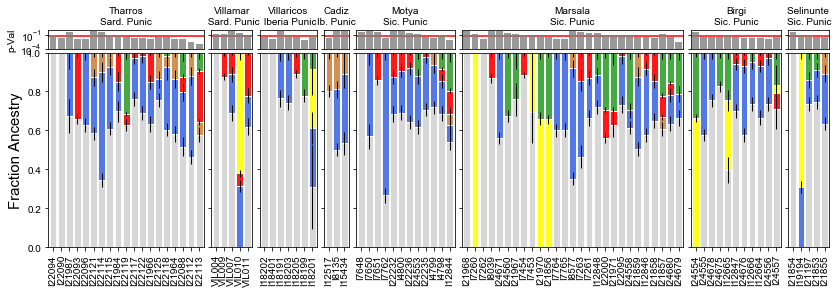

In [35]:
df1 = get_individual_models(df, min_p=0.01, feasible=True)
print(f"Loaded {len(df1)} individual best qpAdm models.")
df1 = pd.merge(df1, df_ts, left_on="t", right_on="iid", how="left")
print(f"Merged to {len(df1)} Individuals with all data")

dfs = get_dfs_from_dfq(df1, dfq, min_p=0.0001,
                       labels=["Tharros", "Villamar", "Almeria", "Cadiz", 
                               "Motya", "Marsala", "Birgi", "Selinunte"])

lbl_plot = ["Tharros\nSard. Punic", "Villamar\n Sard. Punic", "Villaricos\n Iberia Punic", 
            "Cadiz\nIb. Punic", "Motya\nSic. Punic", "Marsala\nSic. Punic", "Birgi\nSic. Punic",
            "Selinunte \nSic. Punic"]

sources = ["Anatolia N", "Steppe MLBA", "WHG", 
               "Tunisia N", "Levant N", "Iran N"]
c = ["lightgray", "royalblue", "peru", "red", "yellow", "#33a02c"]

plot_qpadm_split(dfs, sources=sources, figsize=(14, 4), labels=lbl_plot,
                 bw = 0.85, lw=1,
                 c=c, ec="white", fs=10, 
                 height_ratios=[1, 10], wspace=0.08, hspace=0.03,
                 pval_lim = [1e-4, 1], pr=False, save_path="", 
                 legend=False, l_pos=(-0.25, 0.9))

### Plot Reference Populations

Loaded 193 individual best qpAdm models.
Merged to 193 Individuals with all data


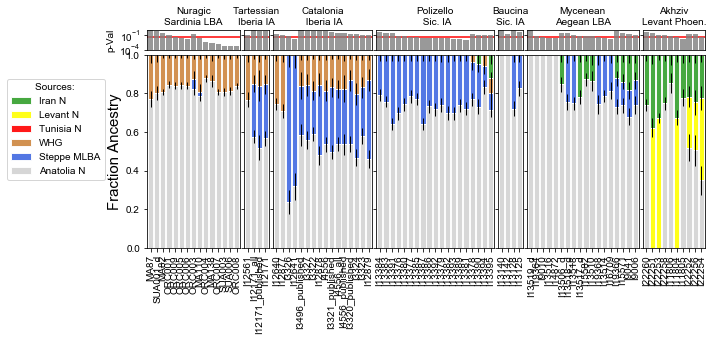

In [37]:
df1 = get_individual_models(df, min_p=0.01, feasible=True, best_p=False)
print(f"Loaded {len(df1)} individual best qpAdm models.")
df1 = pd.merge(df1, df_ts, left_on="t", right_on="iid", how="left")
print(f"Merged to {len(df1)} Individuals with all data")


dfs = get_dfs_from_dfq(df1, dfq, min_p=0.0001,
                       labels=["Sardinia", "Tartessian", "Spain IA", 
                               "Polizello", "Baucina",
                               "Mycenean", "Akhziv"])

lbl_plot = ["Nuragic\nSardinia LBA", "Tartessian\nIberia IA", "Catalonia\n Iberia IA", "Polizello\n Sic. IA", 
            "Baucina\nSic. IA", 
            "Mycenean\nAegean LBA", "Akhziv\nLevant Phoen."]

sources = ["Anatolia N", "Steppe MLBA", "WHG", 
               "Tunisia N", "Levant N", "Iran N"]
c = ["lightgray", "royalblue", "peru", "red", "yellow", "#33a02c"]

plot_qpadm_split(dfs, sources=sources, figsize=(10,4), labels=lbl_plot,
                 bw = 0.85, lw=1,
                 c=c, ec="white", fs=10, 
                 height_ratios=[1, 10], wspace=0.05, hspace=0.05,
                 pval_lim = [1e-4, 1], pr=False, save_path="", 
                 legend=True, l_pos=(-0.4, 0.9))

In [ ]:
dfs[-1]

# Best p-Value

Loaded 193 individual best qpAdm models.
Merged to 193 Individuals with all data


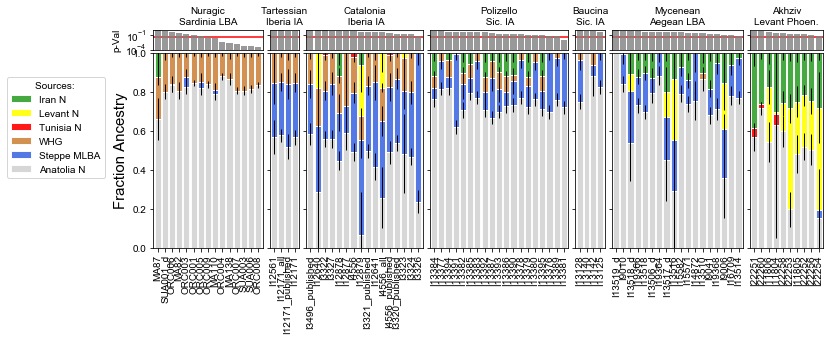

In [40]:
df1 = get_individual_models(df, min_p=0.01, feasible=True, best_p=True)
print(f"Loaded {len(df1)} individual best qpAdm models.")
df1 = pd.merge(df1, df_ts, left_on="t", right_on="iid", how="left")
print(f"Merged to {len(df1)} Individuals with all data")


dfs = get_dfs_from_dfq(df1, dfq, min_p=0.0001,
                       labels=["Sardinia", "Tartessian", "Spain IA", 
                               "Polizello", "Baucina",
                               "Mycenean", "Akhziv"])

lbl_plot = ["Nuragic\nSardinia LBA", "Tartessian\nIberia IA", "Catalonia\n Iberia IA", "Polizello\n Sic. IA", 
            "Baucina\nSic. IA", 
            "Mycenean\nAegean LBA", "Akhziv\nLevant Phoen."]

sources = ["Anatolia N", "Steppe MLBA", "WHG", 
               "Tunisia N", "Levant N", "Iran N"]
c = ["lightgray", "royalblue", "peru", "red", "yellow", "#33a02c"]

plot_qpadm_split(dfs, sources=sources, figsize=(12,4), labels=lbl_plot,
                 bw = 0.85, lw=1,
                 c=c, ec="white", fs=10, 
                 height_ratios=[1, 10], wspace=0.08, hspace=0.03,
                 pval_lim = [1e-4, 1], pr=False, save_path="", 
                 legend=True, l_pos=(-0.4, 0.9))

In [ ]:
df1["clst"].value_counts()

Loaded 193 individual best qpAdm models.
Merged to 193 Individuals with all data


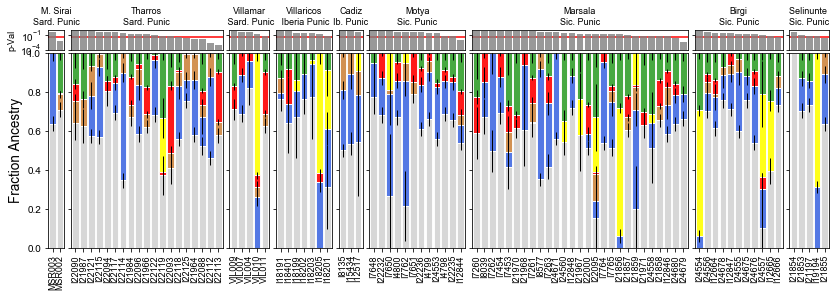

In [38]:
df1 = get_individual_models(df, min_p=0.05, feasible=True, best_p=True)
print(f"Loaded {len(df1)} individual best qpAdm models.")
df1 = pd.merge(df1, df_ts, left_on="t", right_on="iid", how="left")
print(f"Merged to {len(df1)} Individuals with all data")

dfs = get_dfs_from_dfq(df1, dfq, min_p=0.001,
                       labels=["Monte Sirai", "Tharros", "Villamar", "Almeria", "Cadiz", 
                               "Motya", "Marsala", "Birgi", "Selinunte"])

lbl_plot = ["M. Sirai\nSard. Punic", "Tharros\nSard. Punic", "Villamar\n Sard. Punic", "Villaricos\n Iberia Punic", 
            "Cadiz\nIb. Punic", "Motya\nSic. Punic", "Marsala\nSic. Punic", "Birgi\nSic. Punic",
            "Selinunte \nSic. Punic"]

sources = ["Anatolia N", "Steppe MLBA", "WHG", 
               "Tunisia N", "Levant N", "Iran N"]
c = ["lightgray", "royalblue", "peru", "red", "yellow", "#33a02c"]

plot_qpadm_split(dfs, sources=sources, figsize=(14, 4), labels=lbl_plot,
                 bw = 0.85, lw=1,
                 c=c, ec="white", fs=9, 
                 height_ratios=[1, 10], wspace=0.08, hspace=0.03,
                 pval_lim = [1e-4, 1], pr=False, save_path="", 
                 legend=False, l_pos=(-0.25, 0.9))

# Best Model with Steppe as outgroup

Found 5983/12159 models without ['Steppe_MLBA'].
Loaded 193 individual best qpAdm models.
Merged to 193 Individuals with all data


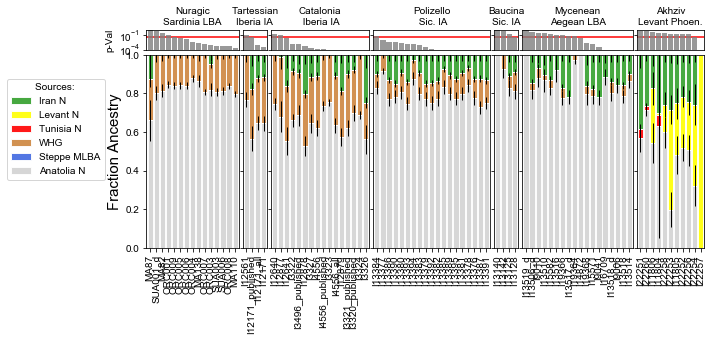

In [32]:
dft = df_excl_source(df, exclude=["Steppe_MLBA"], tot_sources=5, output=True)
df1 = get_individual_models(dft, min_p=0.01, feasible=True, best_p=True)


print(f"Loaded {len(df1)} individual best qpAdm models.")
df1 = pd.merge(df1, df_ts, left_on="t", right_on="iid", how="left")
print(f"Merged to {len(df1)} Individuals with all data")


dfs = get_dfs_from_dfq(df1, dfq, min_p=0.0,
                       labels=["Sardinia", "Tartessian", "Spain IA", 
                               "Polizello", "Baucina",
                               "Mycenean", "Akhziv"])

lbl_plot = ["Nuragic\nSardinia LBA", "Tartessian\nIberia IA", "Catalonia\n Iberia IA", "Polizello\n Sic. IA", 
            "Baucina\nSic. IA", 
            "Mycenean\nAegean LBA", "Akhziv\nLevant Phoen."]

sources = ["Anatolia N", "Steppe MLBA", "WHG", 
               "Tunisia N", "Levant N", "Iran N"]
c = ["lightgray", "royalblue", "peru", "red", "yellow", "#33a02c"]

plot_qpadm_split(dfs, sources=sources, figsize=(10,4), labels=lbl_plot,
                 bw = 0.85, lw=1,
                 c=c, ec="white", fs=10, 
                 height_ratios=[1, 10], wspace=0.05, hspace=0.05,
                 pval_lim = [1e-4, 1], pr=False, save_path="", 
                 legend=True, l_pos=(-0.4, 0.9))

Found 5983/12159 models without ['Steppe_MLBA'].
Loaded 193 individual best qpAdm models.
Merged to 193 Individuals with all data


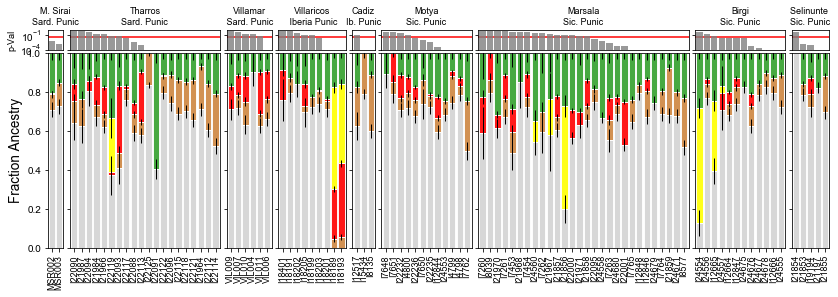

In [31]:
dft = df_excl_source(df, exclude=["Steppe_MLBA"], tot_sources=6, output=True)
df1 = get_individual_models(dft, min_p=0.05, feasible=True, best_p=True)
print(f"Loaded {len(df1)} individual best qpAdm models.")
df1 = pd.merge(df1, df_ts, left_on="t", right_on="iid", how="left")
print(f"Merged to {len(df1)} Individuals with all data")

dfs = get_dfs_from_dfq(df1, dfq, min_p=0.0,
                       labels=["Monte Sirai", "Tharros", "Villamar", "Almeria", "Cadiz", 
                               "Motya", "Marsala", "Birgi", "Selinunte"])

lbl_plot = ["M. Sirai\nSard. Punic", "Tharros\nSard. Punic", "Villamar\n Sard. Punic", "Villaricos\n Iberia Punic", 
            "Cadiz\nIb. Punic", "Motya\nSic. Punic", "Marsala\nSic. Punic", "Birgi\nSic. Punic",
            "Selinunte \nSic. Punic"]

sources = ["Anatolia N", "Steppe MLBA", "WHG", 
               "Tunisia N", "Levant N", "Iran N"]
c = ["lightgray", "royalblue", "peru", "red", "yellow", "#33a02c"]

plot_qpadm_split(dfs, sources=sources, figsize=(14, 4), labels=lbl_plot,
                 bw = 0.85, lw=1,
                 c=c, ec="white", fs=9, 
                 height_ratios=[1, 10], wspace=0.08, hspace=0.03,
                 pval_lim = [1e-4, 1], pr=False, save_path="", 
                 legend=False, l_pos=(-0.25, 0.9))

# Use Algerian IA as North African Source

In [76]:
df_ts = pd.read_csv("./output/tables/qpadm.targets.distal.v46.3.tsv", sep="\t")
print(f"Loaded {len(df_ts)} Targets")

df = pd.read_csv("./output/qpAdm/v46.3/ind_model_distAlgIA.tsv", sep="\t")
df = set_feasible_df(df, sources=6)
df.loc[df["t"] == "MA112_renamed", "t"] = "MA112"
df["t"] = df["t"].str.replace("_published", "")

dfq = pd.read_csv("./data/qpAdm_pops.tsv", sep="\t")
#df_meta = pd.read_csv("/n/groups/reich/hringbauer/Data/v46.3.anno.csv")

Loaded 194 Targets
Set 6897/12096 infeasible models


Loaded 190 individual best qpAdm models.
Merged to 190 Individuals with all data
Filtered to 149 Individuals with 100k SNPs


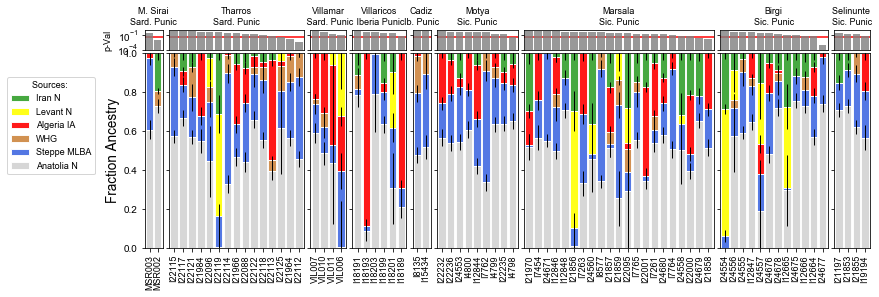

In [16]:
df1 = get_individual_models(df, min_p=0.05, feasible=True, best_p=True)
print(f"Loaded {len(df1)} individual best qpAdm models.")
df1 = pd.merge(df1, df_ts, left_on="t", right_on="iid", how="left")
print(f"Merged to {len(df1)} Individuals with all data")
df1 = df1[df1["n_cov_snp"]>1e5]
print(f"Filtered to {len(df1)} Individuals with 100k SNPs")

dfs = get_dfs_from_dfq(df1, dfq, min_p=0.0001,
                       labels=["Monte Sirai", "Tharros", "Villamar", "Almeria", "Cadiz", 
                               "Motya", "Marsala", "Birgi", "Selinunte"])

lbl_plot = ["M. Sirai\nSard. Punic", "Tharros\nSard. Punic", 
            "Villamar\n Sard. Punic", "Villaricos\n Iberia Punic", 
            "Cadiz\nIb. Punic", "Motya\nSic. Punic", 
            "Marsala\nSic. Punic", "Birgi\nSic. Punic",
            "Selinunte \nSic. Punic"]

sources = ["Anatolia N", "Steppe MLBA", "WHG", 
               "Algeria IA", "Levant N", "Iran N"]

c = ["lightgray", "royalblue", "peru", 
     "red", "yellow", "#33a02c"]

plot_qpadm_split(dfs, sources=sources, figsize=(13, 4), labels=lbl_plot,
                 bw = 0.85, lw=1,
                 c=c, ec="white", fs=9, 
                 height_ratios=[1, 10], wspace=0.08, hspace=0.03,
                 pval_lim = [1e-4, 1], pr=False, save_path="", 
                 legend=True, l_pos=(-2.5, 0.9))

Loaded 190 individual best qpAdm models.
Merged to 190 Individuals with all data
Filtered to 149 Individuals with 100k SNPs


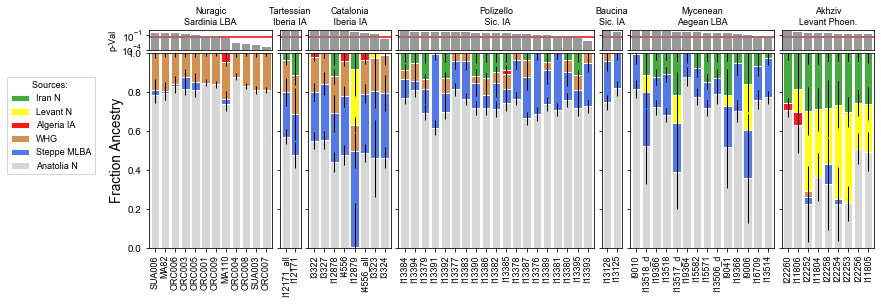

In [4]:
df1 = get_individual_models(df, min_p=0.01, feasible=True, best_p=True)
print(f"Loaded {len(df1)} individual best qpAdm models.")
df1 = pd.merge(df1, df_ts, left_on="t", right_on="iid", how="left")
print(f"Merged to {len(df1)} Individuals with all data")
df1 = df1[df1["n_cov_snp"]>1e5]
print(f"Filtered to {len(df1)} Individuals with 100k SNPs")

dfs = get_dfs_from_dfq(df1, dfq, min_p=0.0001,
                       labels=["Sardinia", "Tartessian", "Spain IA", 
                               "Polizello", "Baucina",
                               "Mycenean", "Akhziv"])

lbl_plot = ["Nuragic\nSardinia LBA", "Tartessian\nIberia IA", "Catalonia\n Iberia IA", "Polizello\n Sic. IA", 
            "Baucina\nSic. IA", 
            "Mycenean\nAegean LBA", "Akhziv\nLevant Phoen."]

sources = ["Anatolia N", "Steppe MLBA", "WHG", 
               "Algeria IA", "Levant N", "Iran N"]
c = ["lightgray", "royalblue", "peru", "red", "yellow", "#33a02c"]

plot_qpadm_split(dfs, sources=sources, figsize=(13,4), labels=lbl_plot,
                 bw = 0.85, lw=1,
                 c=c, ec="white", fs=9, 
                 height_ratios=[1, 10], wspace=0.08, hspace=0.03,
                 pval_lim = [1e-4, 1], pr=False, save_path="", 
                 legend=True, l_pos=(-0.4, 0.9))

In [48]:
df = pd.DataFrame({"a":[0]})

In [51]:
df

,a
0,0


In [52]:
df.shape[0]

1

# 2) Show the Competitive Proximal Models

In [44]:
df_ts = pd.read_csv("./output/tables/qpadm.targets.distal.v46.3.tsv", sep="\t")
print(f"Loaded {len(df_ts)} Targets")

df = pd.read_csv("./output/qpAdm/v46.3/ind_model_comp2r.tsv", sep="\t")
df = set_feasible_df(df, sources=6) ## Add Feasibility of Model
#df.loc[df["t"] == "MA112_renamed", "t"] = "MA112"

dfq = pd.read_csv("./data/qpAdm_pops.tsv", sep="\t")
#df_meta = pd.read_csv("/n/groups/reich/hringbauer/Data/v46.3.anno.csv")

Loaded 194 Targets
Set 3643/7000 infeasible models


Loaded 125 individual best qpAdm models.
Merged to 125 Individuals with all data


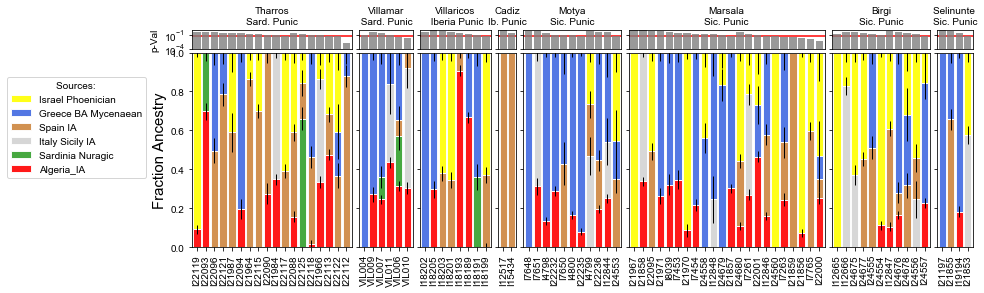

In [45]:
df1 = get_individual_models(df, min_p=0.05, feasible=True)
print(f"Loaded {len(df1)} individual best qpAdm models.")
df1 = pd.merge(df1, df_ts, left_on="t", right_on="iid", how="left")
print(f"Merged to {len(df1)} Individuals with all data")

dfs = get_dfs_from_dfq(df1, dfq, min_p=0.001,
                       labels=["Tharros", "Villamar", "Almeria", "Cadiz", 
                               "Motya", "Marsala", "Birgi", "Selinunte"])

lbl_plot = ["Tharros\nSard. Punic", "Villamar\n Sard. Punic", "Villaricos\n Iberia Punic", 
            "Cadiz\nIb. Punic", "Motya\nSic. Punic", "Marsala\nSic. Punic", "Birgi\nSic. Punic",
            "Selinunte \nSic. Punic"]
["Algeria_IA", "Italy_Sicily_IA_Polizzello", "Italy_Sardinia_BA_Nuragic", 
              "Spain_IA", "Greece_BA_Mycenaean",  "Israel_Phoenician"]


sources = ["Algeria_IA", "Sardinia Nuragic", "Italy Sicily IA", 
           "Spain IA", "Greece BA Mycenaean", "Israel Phoenician"]

c = ["red", "#33a02c", "lightgray", "peru", "royalblue", "yellow"]

plot_qpadm_split(dfs, sources=sources, figsize=(14, 4), labels=lbl_plot,
                 bw = 0.85, lw=1,
                 c=c, ec="white", fs=10, 
                 height_ratios=[1, 10], wspace=0.08, hspace=0.03,
                 pval_lim = [1e-4, 1], pr=False, save_path="", 
                 legend=True, l_pos=(-0.25, 0.9))

# Show all feasible Models for 1 Individual

# Produce a catalogue of all proximal plots and do a visualization

In [5]:
df = pd.read_csv("./output/qpAdm/v46.3/ind_model_comp2r.tsv", sep="\t")
df = set_feasible_df(df, sources=6) ## Add 
df1  = df[df["fs"]==True] # Extract Feasible Models
df2 = df1[df1["p"]>=0.05] # Extract models with allele frequency

iids = list(set(df2["t"]))
print(f"Found valid models for {len(iids)} IIDs")

Set 3643/7000 infeasible models
Found valid models for 105 IIDs


In [ ]:
df = pd.read_csv("./output/qpAdm/v46.3/ind_model_comp2r.tsv", sep="\t")
df[df["t"]=="I24205"]

In [8]:
def plot_proximal(df, iid, save_path=""):
    """Plot all valide proximal models in df
    for target iid"""
    dft = df[df["t"]==iid]
    ns = set(dft["n"])

    lbl_plot = [f"n={i}" for i in ns]
    dfs = [dft[dft["n"]==i].copy() for i in ns]

    sources = ["Algeria_IA", "Sardinia Nuragic", "Italy Sicily IA", 
               "Spain IA", "Greece BA Mycenaean", "Israel Phoenician"]

    c = ["red", "#33a02c", "lightgray", "peru", "royalblue", "yellow"]

    plot_qpadm_split(dfs, sources=sources, 
                     figsize=(len(dft)/2, 4), labels=lbl_plot,
                     bw = 0.85, lw=1,
                     c=c, ec="white", fs=10, 
                     height_ratios=[1, 10], wspace=0.4, hspace=0.05,
                     pval_lim = [1e-4, 1], pr=False, save_path=save_path, 
                     legend=True, l_pos=(-2, 0.9))

### Single IID Example

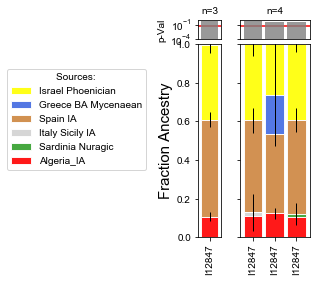

In [9]:
plot_proximal(df2, iid="I12847")

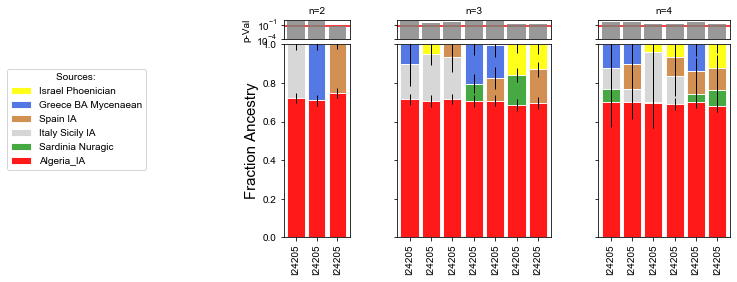

In [11]:
plot_proximal(df2, iid="I24205") # Kerkouene Indivdiual

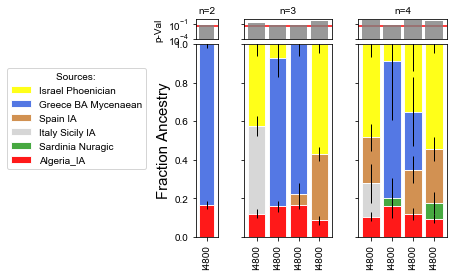

In [10]:
plot_proximal(df2, iid="I4800")

### Run all IIDs with valid models

In [ ]:
for iid in iids:
    print(f"Running: {iid}")
    plot_proximal(df2, iid=iid, 
                  save_path=f"./figures/qpAdm.49.2/proximal_iid/{iid}.pdf")

# Visualize Ancestry Components of Proximal Models with uncertainty across models

In [45]:
### FILL IN: Extract all models for one individual

def extract_frac(df, iid="", source="1"):
    """Return Admixture Fracions. """
    dft = df[df["t"]==iid]
    if len(dft)==0:
        print(f"Warning. IID {iid} not found.")
    #assert(len(dft)>0) # To check whether IID was found
    dft1 = dft[[f"f{source}",f"std{source}", "p"]]
    dft1.columns = ["f", "std", "p"]
    return dft1

### Load the Data

In [21]:
df = pd.read_csv("./output/qpAdm/v46.3/ind_model_comp2r.tsv", sep="\t")
iids = set(df["t"])
print(f"Loaded models for {len(iids)} Individuals")
df = set_feasible_df(df, sources=6) ## Add 
df1  = df[df["fs"]==True]
df1 = df1[df1["p"]>0.05]

df_c = pd.read_csv("./data/cluster_assignments_punic.v49.2.tsv", sep="\t")
print(f"Loaded {len(df_c)} cluster annotated Individuals")

df_early = df_c[df_c["label"]=="Punic_Early"]
df_late = df_c[df_c["label"]=="Punic_Late"]
df_kerk = df_c[df_c["label"]=="Punic_Kerk"]

Loaded models for 125 Individuals
Set 3643/7000 infeasible models
Loaded 106 cluster annotated Individuals


In [19]:
### Extract for one aDNA. Test Case
extract_frac(df1, iid="I12847", source="6")

,f,std,p
2739,0.389,0.044,0.467799
5204,0.395,0.060,0.539818
5211,0.265,0.122,0.324132
5213,0.392,0.042,0.324111


In [23]:
%%time
fracs =  [extract_frac(df1, iid=iid, source="1") for iid in df_early["iid"]]
print("Fitting Models per indivdiual:")
print([len(f) for f in fracs])

fracs_late =  [extract_frac(df1, iid=iid, source="1") for iid in df_late["iid"]]
print("\nFitting Models per late indivdiual:")
print([len(f) for f in fracs_late])

fracs_kerk =  [extract_frac(df1, iid=iid, source="1") for iid in df_kerk["iid"]]
print("\nFitting Models per late indivdiual:")
print([len(f) for f in fracs_kerk])

Fitting Models per indivdiual:
[11, 4, 3, 4, 7, 4, 8, 7, 9, 9, 4, 1, 4, 13, 2, 1, 5, 12]

Fitting Models per late indivdiual:
[6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 2, 14, 3, 0, 1, 2, 4, 5, 2, 9, 1, 0, 10, 0, 2, 2, 3, 7, 0, 7, 12, 15, 7, 8, 1, 0, 0, 9, 13, 11]

Fitting Models per late indivdiual:
[16, 6, 8, 11, 3, 2, 4, 5, 5, 9, 2, 5, 12, 5, 13, 6, 5, 16, 4, 13, 14, 5, 11, 3, 6, 6, 13]
CPU times: user 194 ms, sys: 5.88 ms, total: 200 ms
Wall time: 182 ms


In [166]:
def get_mean_frac(df):
    """Get the fraction with the best p-Value
    Return fraction and its std"""
    if len(df)==0:
        return np.nan, np.nan
    
    idx =np.argmax(df["p"])
    return  df["f"].values[idx], df["std"].values[idx]

def plot_fracs(fracs, ax=0, iids=[], figsize=(5,5), title="",
               show=True, ylabel = "North African Ancestry [%]"):
    """Plot Fractions of North African Admixture"""
    
    if not ax:
        plt.figure(figsize=figsize)
        ax = plt.gca()

    for i,df in enumerate(fracs):
        ys = df["f"].values
        
        ### Get Medium
        f, std = get_mean_frac(df)
        
        ax.bar(i, f, width=0.9, zorder=0, color="red", ec="k")
        ax.scatter([i]*len(ys), ys, c="gray", ec="k", zorder=2, clip_on=False, s=20)
        ax.set_ylim([0,1.0])
        
        ax.errorbar(i, f, yerr=std, fmt='none', color="k", zorder=1)
        
    
    if len(iids)>0:
        ax.set_xticks(range(0,len(iids)))
        ax.set_xticklabels(iids, fontsize=9, rotation=90)
        ax.set_xlim([-0.5, len(iids)-0.5])
        
    if len(ylabel)==0:
        ax.axes.yaxis.set_ticklabels([])
    else:
        ax.set_ylabel(ylabel)
        
    if len(title)>0:
        ax.set_title(title)
        
    if show:
        plt.show()
        
        
def plot_fracs_panel(fracs_list, iids_ls=[], 
                     figsize=(8,6), save_path="",
                     titles=[], wspace=1):
    """Plot Fractions of Panel of Populations"""
    
    ### Filter for empty indivdiuals
    ns = np.array(list(map(len, fracs_list)))
    idx = np.where(ns>0)[0]
    
    fracs_list = [fracs_list[i] for i in idx]
    iids_ls = [iids_ls[i] for i in idx]
    titles = [titles[i] for i in idx]
    
    ### Calculate remaining Fractions
    width_ratios = list(map(len, fracs_list))
    
    
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(1, len(fracs_list), 
                           width_ratios = width_ratios, 
                           figure = fig)
    
    gs.update(wspace=wspace) # set the spacing between axes
    
    for i in range(len(fracs_list)):
        ax = fig.add_subplot(gs[i])
        iids = iids_ls[i]
        title = titles[i]
        if i==0:
            ylabel = "North African Ancestry [%]"
        else: 
            ylabel = ""
            
        plot_fracs(fracs_list[i], ax=ax, iids=iids, title=title,
                   show=False, ylabel=ylabel)

    if len(save_path)>0:
        plt.savefig(save_path, bbox_inches = 'tight', 
                        pad_inches = 0)
        print(f"Saved Figure to {save_path}!")
      
    plt.show()
    
    return


def extract_fracs_list(df, df_meta, sites, label_sites, s=1, 
                       col_meta="label_fine", sort=False, filter0=False):
    """Extract Fractions from qpAdm results.
    Retunrs iids [[], ...], fracs [[], ...] and numbers []
    df: Dataframe with Admixture Fractions
    df_meta: Dataframe with Meta Info
    s: What Source Index to extract (usually s=1 North Africa)
    sort: Whether to sort by Admixture Fraction
    filter0: Whether to sort Indivdiuals with 0 fitting models"""
    
    iids_ls = [df_meta[df_meta[col_meta].str.contains(p)]["iid"].values for p in sites]
    fracs_ls =  [[extract_frac(df, iid=iid, source=s) for iid in iids] for iids in iids_ls]
   
    
    ### Filter Indivdiuals that are not there
    if filter0:
        for i in range(len(fracs_ls)): # Sort within each site
            n_mods = np.array([len(df) for df in fracs_ls[i]])
            idx = n_mods>0
            nn = range(len(iids_ls[i]))
            
            iids_ls[i] = np.array([iids_ls[i][j] for j in nn if idx[j]>0])
            fracs_ls[i] = [fracs_ls[i][j] for j in nn if idx[j]>0]
        
    if sort:
        for i in range(len(fracs_ls)): # Sort within each site
            
            fracs = [np.median(df["f"]) for df in fracs_ls[i]]
            idx = np.argsort(fracs)[::-1]
            iids_ls[i] = iids_ls[i][idx]
            
            fracs_new = [fracs_ls[i][j] for j in idx]
            fracs_ls[i] = fracs_new
    
    n_ls = np.sum([len(x) for x in iids_ls])
    
    return iids_ls, fracs_ls, n_ls

## Prepare List of Admixture Fractions per Site

In [112]:


iid_ls_early = [df_early[df_early["label_fine"].str.contains(p)]["iid"].values for p in sites_early]
fracs_early =  [[extract_frac(df1, iid=iid, source=s) for iid in iids] for iids in iid_ls_early]
n_early = np.sum([len(x) for x in iid_ls_early])


iid_ls_late = [df_late[df_late["label_fine"].str.contains(p)]["iid"].values for p in sites_late]
fracs_late =  [[extract_frac(df1, iid=iid, source=s) for iid in iids] for iids in iid_ls_late]
n_late = np.sum([len(x) for x in iid_ls_late])

#iid_ls_late = [df_late[df_late["label_fine"].str.contains(p)]["iid"].values for p in sites_late]

{'Tharros_Late', 'Marsala_Late', 'Eivissa', 'MonteSirai_Late', 'Birgi_Late', 'Villamar_Late', 'Cadiz', 'Villaricos_Late', 'Malaga', 'Selinunte_Late'}
Warning. IID I26844 not found.
Warning. IID I26842 not found.
Warning. IID I26915 not found.
Warning. IID I26931 not found.
Warning. IID I26932 not found.
Warning. IID I22114 not found.
Warning. IID VIL010 not found.
Warning. IID VIL006 not found.
Warning. IID I24671 not found.
Warning. IID I21859 not found.
Warning. IID I8577 not found.


## Plot Punic Early

In [168]:
s=1

print(set(df_early["label_fine"]))
sites_early = ["Cadiz", "Lilybaeum", "Motya", "Tharros"]
labels_early = ["Cadiz,\nIberia", "Lilybaeum\nSicily", "Motya,\nSicily","Tharros,\nSardinia"]

iid_ls_early, fracs_early, n_early = extract_fracs_list(df1, df_early, sites_early, labels_early, s=1, 
                                                        sort=True, filter0=True)

{'Motya_Early', 'Tharros_Early', 'Cadiz', 'Lilybaeum_Early'}


Saved Figure to ./figures/qpAdm.49.2/nafr_ancestry/punic_early.pdf!


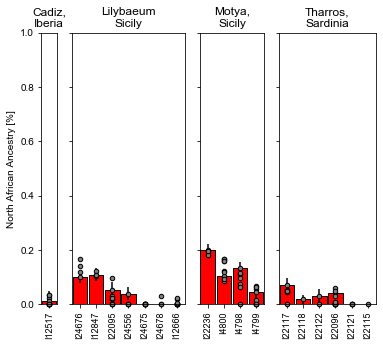

In [169]:
plot_fracs_panel(figsize=(n_early/3,5), fracs_list=fracs_early, iids_ls=iid_ls_early, titles=labels_early,
                 wspace=0.2, save_path="./figures/qpAdm.49.2/nafr_ancestry/punic_early.pdf")

## Plot PunicLate

In [160]:
print(set(df_late["label_fine"]))
sites_late = ["Cadiz", "Malaga", "Villaricos", "Tharros", 
              "Villamar", "MonteSirai",
              "Marsala", "Birgi", "Selinunte"]
labels_late = ["Cadiz,\nIberia", "Malaga\nIberia", "Villaricos\nIberia", "Tharros\nSardinia", 
               "Villamar\nSardinia", "Monte Sirai\nSardinia", 
               "Marsala\nSicily", "Birgi\nSicily", "Selinunte\nSicily"]

iid_ls_late, fracs_late, n_late = extract_fracs_list(df1, df_late, sites_late, labels_late, s=1, 
                                                     sort=True, filter0=True)

{'Tharros_Late', 'Marsala_Late', 'Eivissa', 'MonteSirai_Late', 'Birgi_Late', 'Villamar_Late', 'Cadiz', 'Villaricos_Late', 'Malaga', 'Selinunte_Late'}
Warning. IID I26844 not found.
Warning. IID I26842 not found.
Warning. IID I26915 not found.
Warning. IID I26931 not found.
Warning. IID I26932 not found.
Warning. IID I22114 not found.
Warning. IID VIL010 not found.
Warning. IID VIL006 not found.
Warning. IID I24671 not found.
Warning. IID I21859 not found.
Warning. IID I8577 not found.


Saved Figure to ./figures/qpAdm.49.2/nafr_ancestry/punic_late.pdf!


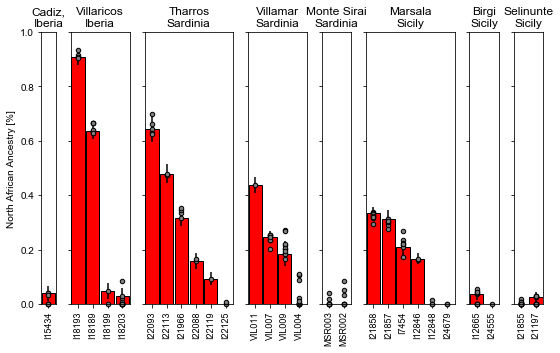

In [167]:
plot_fracs_panel(figsize=(n_late/3,5), fracs_list=fracs_late, 
                 iids_ls=iid_ls_late, titles=labels_late,
                 wspace=0.3, save_path="./figures/qpAdm.49.2/nafr_ancestry/punic_late.pdf")

## Plot Kerkouene

In [171]:
s=1 # Which Source to Extract
#print(set(df_kerk["label_fine"]))
sites_kerk = ["Kerkouene"]
labels_kerk = ["Kerkouene, Tunisia"]

iid_ls_kerk, fracs_kerk, n_kerk = extract_fracs_list(df1, df_kerk, 
                                                     sites_kerk, labels_kerk, s=1, sort=True)

Saved Figure to ./figures/qpAdm.49.2/nafr_ancestry/kerk.pdf!


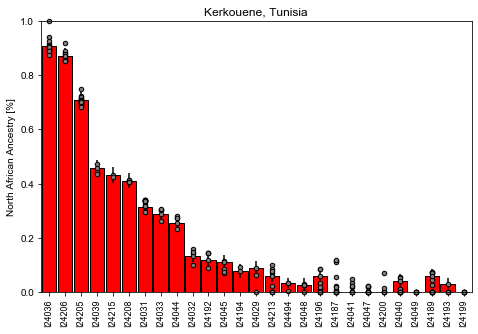

In [174]:
plot_fracs_panel(figsize=(n_kerk/3.5,5), fracs_list=fracs_kerk, 
                 iids_ls=iid_ls_kerk, titles=labels_kerk,
                 wspace=0.3, save_path="./figures/qpAdm.49.2/nafr_ancestry/kerk.pdf")

# Area 51

## Test Loading of Individuals

In [3]:
def load_iids_from_indfile(path_ind, string, 
                           col="clst", col_iid="iid",
                           iids_okay=[]):
    """Load IIDs from Ind File
    Return List of IIDs"""
    df_ind = pd.read_csv(path_ind, delim_whitespace=True, header=None)
    df_ind.columns=["iid", "sex","clst"]
    idx = df_ind[col].str.contains(string)
    ls = df_ind[idx][col_iid].values
    
    ### If needed filter out okay Individuals
    if len(iids_okay)>0:
        ls = np.intersect1d(ls, iids_okay)
    return ls

def load_individuals_filetered(
                            path_anno = "/n/groups/reich/hringbauer/Data/v42.3.anno.csv",
                            col="clst", col_iid="iid",
                            min_snps_cov=50000,
                            snp_cov_col="n_cov_snp",
                            master_id_col="Master ID",
                            ):
    """Filter List of Individuals against meta,
    using minimal Nr of SNPs and unique IDs"""

    df_all = pd.read_csv(path_anno)

    ### Keep only the best coerage Indivdual
    df_all = df_all.sort_values(by=snp_cov_col, ascending=False)
    df_all = df_all.drop_duplicates(subset=master_id_col)
    
    ### Filter to min Nr of SNPs
    df_all = df_all[df_all[snp_cov_col]>=min_snps_cov]
    
    ### 
    df_all = df_all
    return df_all["iid"].values

In [82]:
### Load the ancient Individual Label Data
path_ind = "./eigenstrat/combined/punic.v46.3_ind.ind"
iids = load_individuals_filetered(path_anno='/n/groups/reich/hringbauer/Data/v46.3.anno.csv',
                                 min_snps_cov=1e5)

pops_na = ["Morocco_LN"]
pops_ib_outliers = ["Italy_Sardinia_C_o"]
pops_vil = ["Iberia_Punic_o.3rd", "Iberia_Punic_oEuropean", 
            "Iberia_Punic_o3","Iberia_Punic_oAfrican"]
pops_ibiza = ["Ibiza_Punic"]
pops_nur = ["Italy_Sardinia_BA_Nuragic"]
pops_tar = ["Iberia_Tartessian"]
pops_ib = ["Iberia_Iberian"]
pop_pol = ["Sicily_IA_Polizzello"]
pop_sic = ["Sicani"]
pops_clt =  ["Iberia_Celtiberian"]
pops_nur = ["Nuragic"]

### Add Monte Sirari and Villamar
cadir_inds = ["I12517", "I15434"]
msr_inds = ["MSR002", "MSR003"]
vil_inds = ["VIL004", "VIL006", "VIL007", 
            "VIL009", "VIL010", "VIL011"]
motya_inds= ["I4800", "I4798", "I4799",
            "I7762", "I7650", "I12844"]
birgi_inds = ["I12847", "I12665", "I12666"]
marsala_inds = ["I12846", "I12848", "I7454", "I8577"]
palermo_inds = ["I7764", "I7765"]
sources = ["Anatolia_N", "WHG", "Steppe_EMBA", "I12433"]

pops = [pops_na, pops_ib_outliers, 
        pops_clt, pops_ib, pops_tar,
        pops_nur, pops_vil, pops_ibiza]

all_iids = [[load_iids_from_indfile(path_ind=path_ind, 
                        string=pop, iids_okay=iids) for pop in ls] for ls in pops]
all_iids = [np.concatenate(ls) for ls in all_iids]
all_iids += [cadir_inds, vil_inds, msr_inds, motya_inds, birgi_inds, marsala_inds, palermo_inds]
all_iids[1] = np.append(all_iids[1], "I4246")  # Add the Spanish Outlier

paths = [[".".join([iid]+sources) for iid in ls] for ls in all_iids]
labels = ["Morocco\nLN", "CA\nOutliers",
          "Iberia IA\nCeltib.", "Iberia IA\nIberian", "Iberia IA\nTartessian",
          "Sardinia BA\nNuragic","Villaricos\nPunic", "Ibiza\nPun.", 
          "Cadir\nPunic", "Villamar\nSard. Pun.", "M. Sirai\nSard. Pun.", 
          "Motya\nSicily Pun.", "Birgi\nSic. Pun.", 
          "Marsala\nSic. Pun.", "Palermo\nSic. Pun"]

In [ ]:
all_iids